In [34]:
# Import everything we need
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [10]:
# Just for explore the dataset - Optional
import seaborn as sns

data = pd.read_csv("./Resources/2024_ionosphere_data.csv", header=None)

# 1. Overview of the dataset
print("Shape of dataset:", data.shape)  # (rows, columns)
print("\nFirst 5 rows:\n", data.head())  # View first 5 rows
print("\nColumns in dataset:", data.columns)  # List of columns

# 2. Data types of each column
print("\nData types of columns:\n", data.dtypes)

# 3. Check for missing data
missing_data = data.isnull().sum()
print("\nMissing data in each column:\n", missing_data)

# 4. Summary statistics for numerical features
print("\nSummary statistics for numerical features:\n", data.describe())

# 5. Summary statistics for categorical features
categorical_cols = data.select_dtypes(include=["object", "category"]).columns
print(
    "\nSummary statistics for categorical features:\n",
    data[categorical_cols].describe(),
)

# 6. Unique values in categorical features
for col in categorical_cols:
    print(f"\nUnique values in {col}:", data[col].unique())
    print(f"Value counts in {col}:\n", data[col].value_counts())

# 7. Check for duplicate rows
duplicate_rows = data.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")

Shape of dataset: (351, 35)

First 5 rows:
    0   1        2        3        4        5        6        7        8   \
0   1   0  0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708  1.00000   
1   1   0  1.00000 -0.18829  0.93035 -0.36156 -0.10868 -0.93597  1.00000   
2   1   0  1.00000 -0.03365  1.00000  0.00485  1.00000 -0.12062  0.88965   
3   1   0  1.00000 -0.45161  1.00000  1.00000  0.71216 -1.00000  0.00000   
4   1   0  1.00000 -0.02401  0.94140  0.06531  0.92106 -0.23255  0.77152   

        9   ...       25       26       27       28       29       30  \
0  0.03760  ... -0.51171  0.41078 -0.46168  0.21266 -0.34090  0.42267   
1 -0.04549  ... -0.26569 -0.20468 -0.18401 -0.19040 -0.11593 -0.16626   
2  0.01198  ... -0.40220  0.58984 -0.22145  0.43100 -0.17365  0.60436   
3  0.00000  ...  0.90695  0.51613  1.00000  1.00000 -0.20099  0.25682   
4 -0.16399  ... -0.65158  0.13290 -0.53206  0.02431 -0.62197 -0.05707   

        31       32       33  34  
0 -0.54487  0.18641 -0.45

In [10]:
# Step 1: Load data and preprocessing data
data = pd.read_csv("./Resources/2024_ionosphere_data.csv", header=None)

# Shuffle data
# Opt into the future behavior
pd.set_option("future.no_silent_downcasting", True)

data = data.sample(frac=1).reset_index(drop=True)
data.iloc[:, 34] = data.iloc[:, 34].replace({"g": 1, "b": 0})

# Split to X and Y
X = data.iloc[:, 0:34].values
Y = data.iloc[:, 34:].values

# Scaling values in X
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [51]:
# For testing the changes of number of nodes in hidden layers.
np.random.seed(42)

In [58]:
# Step 2: Create functions to train model
# Initialize weights and biases
# Xavier/Glorot initialization
def initialize_weights(input_dim, hidden_dim, output_dim):
    W1 = np.random.uniform(-1/np.sqrt(input_dim), 1/np.sqrt(input_dim), (input_dim, hidden_dim)).astype(np.float64)
    b1 = np.zeros((1, hidden_dim), dtype=np.float64)
    W2 = np.random.uniform(-1/np.sqrt(hidden_dim), 1/np.sqrt(hidden_dim), (hidden_dim, output_dim)).astype(np.float64)
    b2 = np.zeros((1, output_dim), dtype=np.float64)
    
    return W1, b1, W2, b2

def binary_cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-12  # Small constant to prevent log(0)
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)  # Clip to avoid log(0)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def dbinary_crossentropy_loss(p_pred, y_true):
    return (-y_true / p_pred) + (1 - y_true) / (1 - p_pred)


# Sigmoid activation function
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

# Sigmoid derivative (used in backpropagation)
def sigmoid_derivative(x):
    return x * (1 - x)

# Tanh Function
def tanh(x):
    return np.tanh(x)

# Tanh derivative function
def dtanh(x):
    return 1.0 - np.tanh(x)**2

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# ReLU derivative (for backpropagation)
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Forward propagation
def forward_propagation(X, W1, b1, W2, b2, activation_function = "tanh"):
    Z1 = np.dot(X, W1) + b1 
    if activation_function == "relu":
        A1 = relu(Z1)
    elif activation_function == "sigmoid":
        A1 = sigmoid(Z1)
    elif activation_function == "tanh":
        A1 = tanh(Z1)        
    Z2 = np.dot(A1, W2) + b2 
    A2 = sigmoid(Z2)                  
    return Z1, A1, Z2, A2

def backward_propagation(X, Y, Z1, A1, Z2, A2, W1, W2, activation_function="tanh", lambda_l1=0.01, lambda_l2=0.01):
    m = X.shape[0]  # Number of samples
    
    # Compute the gradients for W2 and b2 with L1 + L2 regularization
    dZ2 = (A2 - Y).astype(np.float64)  # Gradient of the output
    dW2 = ((1/m) * np.dot(A1.T, dZ2) + lambda_l1 * np.sign(W2) + lambda_l2 * W2).astype(np.float64)
    db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True).astype(np.float64)
    
    # Backpropagation to hidden layer
    dA1 = np.dot(dZ2, W2.T).astype(np.float64)
    
    if activation_function == "relu":
        dZ1 = dA1 * relu_derivative(Z1)
    elif activation_function == "sigmoid":
        dZ1 = dA1 * sigmoid_derivative(A1)
    elif activation_function == "tanh":
        dZ1 = dA1 * dtanh(Z1)
    
    # Compute the gradients for W1 and b1 with L1 + L2 regularization
    dW1 = ((1/m) * np.dot(X.T, dZ1) + lambda_l1 * np.sign(W1) + lambda_l2 * W1).astype(np.float64)
    db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True).astype(np.float64)
    
    return dW1, db1, dW2, db2



# Update weights and biases
def update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1.astype(np.float64)  # Ensure weights are float64
    b1 = b1.astype(np.float64)
    W2 = W2.astype(np.float64)
    b2 = b2.astype(np.float64)
    
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    return W1, b1, W2, b2

# Visualize 2D or 3D plot latent spaces during epoches looping
def plot_latent_space(A, Y, title, dim=2):
    if dim == 2:
        # 2D PCA
        pca = PCA(n_components=2)
        A_pca = pca.fit_transform(A)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(A_pca[Y.reshape(-1) == 0, 0], A_pca[Y.reshape(-1) == 0, 1], color='blue', label='Class 0')
        plt.scatter(A_pca[Y.reshape(-1) == 1, 0], A_pca[Y.reshape(-1) == 1, 1], color='red', label='Class 1')
        plt.title(f"{title} - 2D Projection")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.legend()
        plt.grid(True)
        plt.show()

    elif dim == 3:
        # 3D PCA
        pca = PCA(n_components=3)
        A_pca = pca.fit_transform(A)
        
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(A_pca[Y.reshape(-1) == 0, 0], A_pca[Y.reshape(-1) == 0, 1], A_pca[Y.reshape(-1) == 0, 2], color='blue', label='Class 0')
        ax.scatter(A_pca[Y.reshape(-1) == 1, 0], A_pca[Y.reshape(-1) == 1, 1], A_pca[Y.reshape(-1) == 1, 2], color='red', label='Class 1')
        ax.set_title(f"{title} - 3D Projection")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.legend()
        plt.show()


# Save weights and biases
def save_parameters(W1, b1, W2, b2):
    file_path = "./Parameters"
    np.save(f"{file_path}/W1.npy",W1)
    np.save(f"{file_path}/W2.npy",W2)
    np.save(f"{file_path}/b1.npy",b1)
    np.save(f"{file_path}/b2.npy",b2)


In [78]:
# Step 3: Define train function the model - Check here to fix the architecture of NN
def train(
    X,
    Y,
    input_dim,
    hidden_dim,
    output_dim,
    epochs,
    learning_rate,
    train_losses,
    X_test,
    Y_test,
    test_losses,
):
    # Define activation function
    activation_function = "tanh"

    # Initialize weights
    W1, b1, W2, b2 = initialize_weights(input_dim, hidden_dim, output_dim)

    for i in range(epochs):
        # Forward propagation
        Z1, A1, Z2, A2 = forward_propagation(X, W1, b1, W2, b2, activation_function)

        # Calculate loss (MSE for regression)
        loss = binary_cross_entropy_loss(Y, A2)

        # Saving training losses to plot learning curve
        train_losses.append(loss)

        if i % 100 == 0:
            print(f"Epoch {i+1}/{epochs}, Loss: {loss}")
        
        if i == 3000:
            plot_latent_space(A1, Y_train, f"2D features {i} epoches", 2)
            plot_latent_space(A1, Y_train, f"3D features {i} epoches", 3)

        if i == 5000:
            plot_latent_space(A1, Y_train, f"2D features {i} epoches", 2)
            plot_latent_space(A1, Y_train, f"3D features {i} epoches", 3)

        if i == 7000:
            plot_latent_space(A1, Y_train, f"2D features {i} epoches", 2)
            plot_latent_space(A1, Y_train, f"3D features {i} epoches", 3)

        # Backward propagation
        dW1, db1, dW2, db2 = backward_propagation(
            X, Y, Z1, A1, Z2, A2, W1, W2, activation_function
        )

        # Update weights
        W1, b1, W2, b2 = update_weights(
            W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate
        )

        # Test every single version
        _, _, _, Y_pred_heating = forward_propagation(
            X_test, W1, b1, W2, b2, activation_function
        )
        test_loss = binary_cross_entropy_loss(Y_test, Y_pred_heating)
        test_losses.append(test_loss)

    return W1, b1, W2, b2

Epoch 1/7001, Loss: 0.6288536413448177
Epoch 101/7001, Loss: 0.6071324404047125
Epoch 201/7001, Loss: 0.5907777972623726
Epoch 301/7001, Loss: 0.5600618074127648
Epoch 401/7001, Loss: 0.5159505291536571
Epoch 501/7001, Loss: 0.4679777017765469
Epoch 601/7001, Loss: 0.4269289873760046
Epoch 701/7001, Loss: 0.39719873635060243
Epoch 801/7001, Loss: 0.3766406787401942
Epoch 901/7001, Loss: 0.36261958906363717
Epoch 1001/7001, Loss: 0.3526003889993533
Epoch 1101/7001, Loss: 0.34528455592409524
Epoch 1201/7001, Loss: 0.3393018143453918
Epoch 1301/7001, Loss: 0.33462912607231804
Epoch 1401/7001, Loss: 0.33090245705401883
Epoch 1501/7001, Loss: 0.32786437042764693
Epoch 1601/7001, Loss: 0.32470851026239916
Epoch 1701/7001, Loss: 0.32224027758479884
Epoch 1801/7001, Loss: 0.3199798602843929
Epoch 1901/7001, Loss: 0.31823592085874647
Epoch 2001/7001, Loss: 0.3167851190196213
Epoch 2101/7001, Loss: 0.3152768082158463
Epoch 2201/7001, Loss: 0.31406380886281665
Epoch 2301/7001, Loss: 0.31305543195

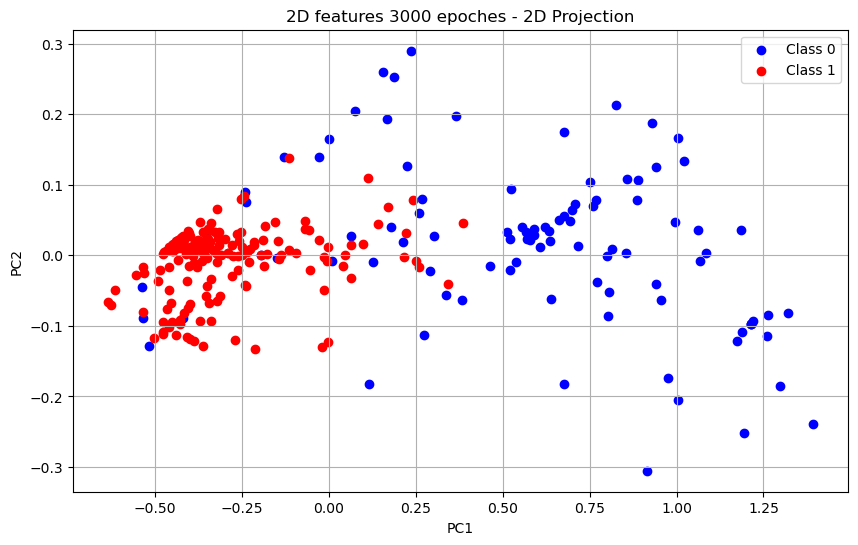

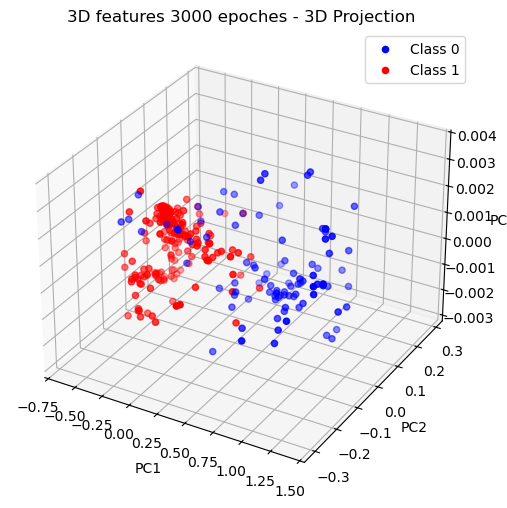

Epoch 3101/7001, Loss: 0.3079821711374698
Epoch 3201/7001, Loss: 0.3075611261462495
Epoch 3301/7001, Loss: 0.3071657808299356
Epoch 3401/7001, Loss: 0.30683864616712464
Epoch 3501/7001, Loss: 0.306542955145784
Epoch 3601/7001, Loss: 0.30613735420556537
Epoch 3701/7001, Loss: 0.30577055206535064
Epoch 3801/7001, Loss: 0.3053472231856425
Epoch 3901/7001, Loss: 0.30475857074134316
Epoch 4001/7001, Loss: 0.30407197726506924
Epoch 4101/7001, Loss: 0.30359180605160774
Epoch 4201/7001, Loss: 0.3030627959296283
Epoch 4301/7001, Loss: 0.302488809594892
Epoch 4401/7001, Loss: 0.30194310190318485
Epoch 4501/7001, Loss: 0.3015682311761975
Epoch 4601/7001, Loss: 0.3012904585497376
Epoch 4701/7001, Loss: 0.3010190876751318
Epoch 4801/7001, Loss: 0.3007519797499976
Epoch 4901/7001, Loss: 0.3005849650968857
Epoch 5001/7001, Loss: 0.3004036992697777


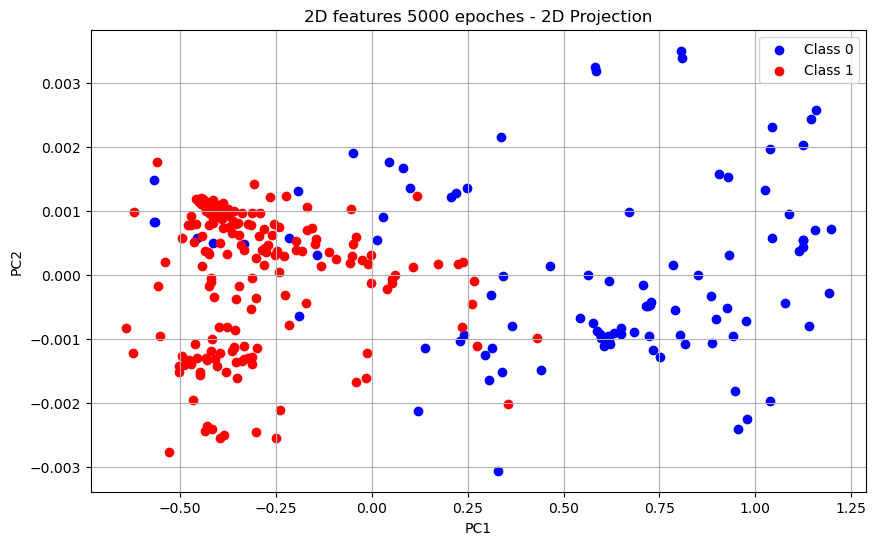

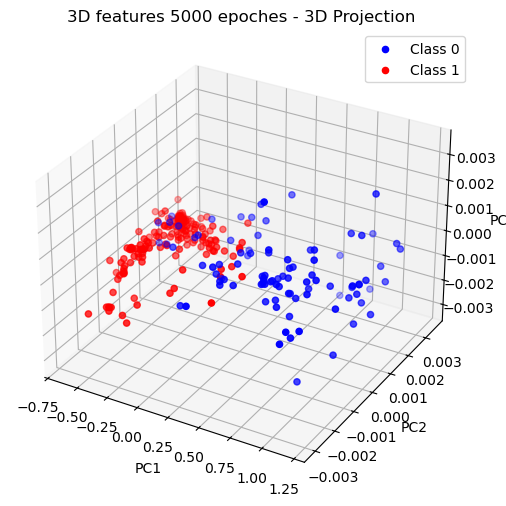

Epoch 5101/7001, Loss: 0.30030384302607255
Epoch 5201/7001, Loss: 0.30014711715518033
Epoch 5301/7001, Loss: 0.3000724598026098
Epoch 5401/7001, Loss: 0.29997973558532814
Epoch 5501/7001, Loss: 0.2998655424776311
Epoch 5601/7001, Loss: 0.2998083498708886
Epoch 5701/7001, Loss: 0.2997668646318431
Epoch 5801/7001, Loss: 0.2997080975215086
Epoch 5901/7001, Loss: 0.2996218147583331
Epoch 6001/7001, Loss: 0.2996537467046319
Epoch 6101/7001, Loss: 0.2995344487900133
Epoch 6201/7001, Loss: 0.2995140372490362
Epoch 6301/7001, Loss: 0.2995300047287627
Epoch 6401/7001, Loss: 0.29941284636837817
Epoch 6501/7001, Loss: 0.2994693087383412
Epoch 6601/7001, Loss: 0.29937195134692635
Epoch 6701/7001, Loss: 0.2993760378379054
Epoch 6801/7001, Loss: 0.2993657833370583
Epoch 6901/7001, Loss: 0.2993711222203037
Epoch 7001/7001, Loss: 0.299298192021268


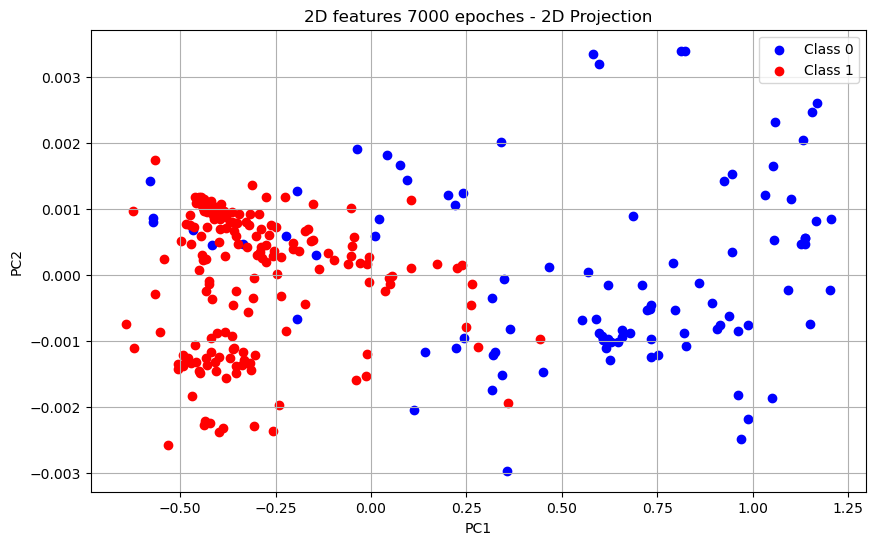

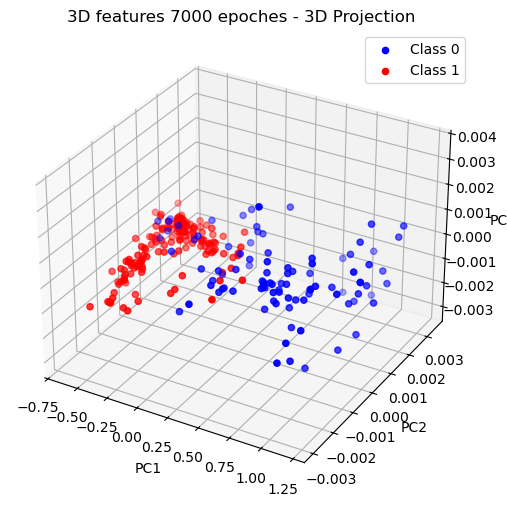

In [83]:
# Step 4: Training with 8 nodes
input_dim = X_train.shape[1]  # Number of features
hidden_dim = 8  # Example hidden layer size (you can adjust this)
output_dim = 1  # Predict one feature is how many percent of good ?
epochs = 7001  # You can adjust the number of epochs
learning_rate = 0.09  # Learning rate for gradient descent
train_losses = []
test_losses = []

# Train the model
W1, b1, W2, b2 = train(
    X_train,
    Y_train,
    input_dim,
    hidden_dim,
    output_dim,
    epochs,
    learning_rate,
    train_losses,
    X_test,
    Y_test,
    test_losses,
)

# Save all weights and biases
save_parameters(W1, b1, W2, b2)

Good or Bad - Binary Cross Entropy Loss on Train Set: 2.86178614702633
Good or Bad - Binary Cross Entropy Loss on Test Set: 2.724187361483342


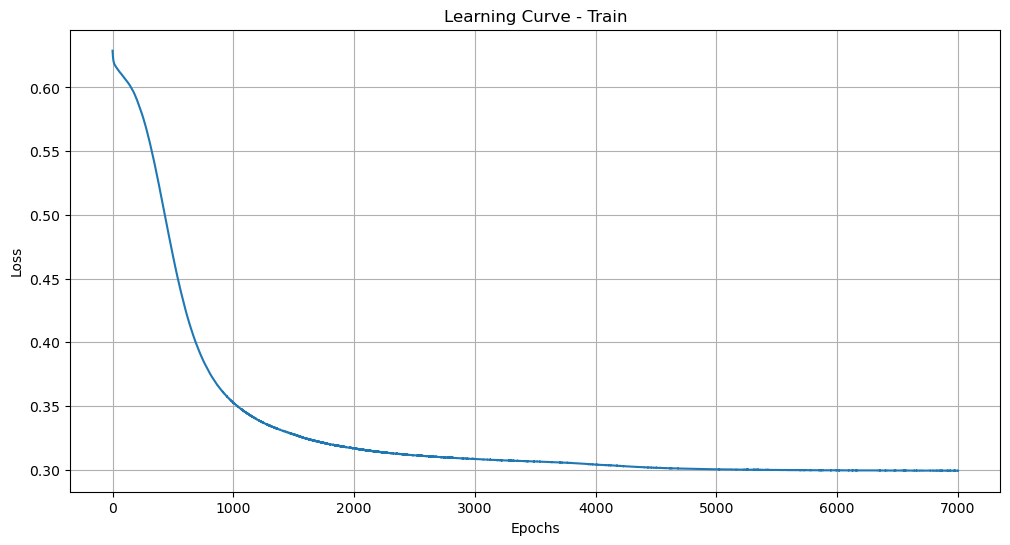

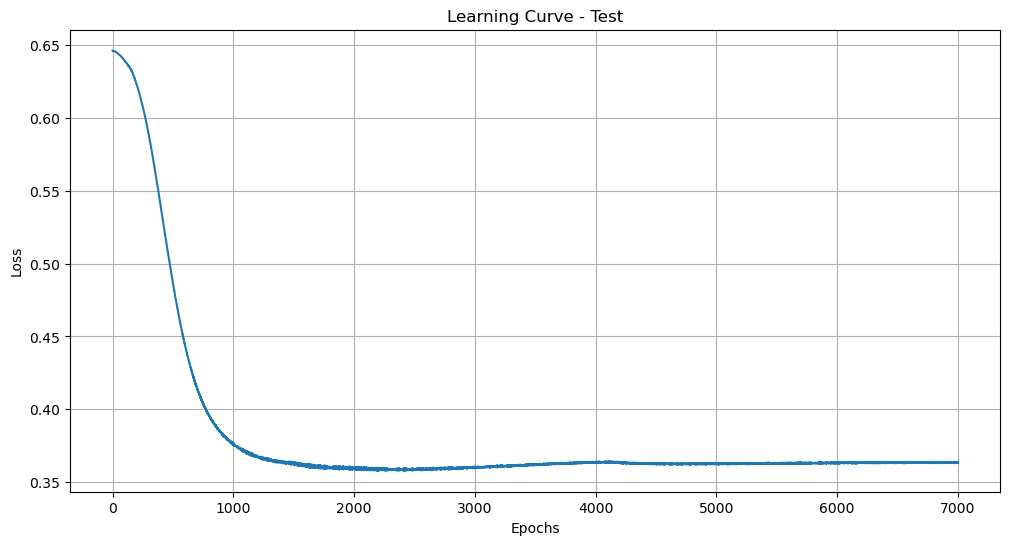

In [84]:
# Question 2-a: Please try to classify the Ionosphere data by minimizing the cross-entropy error function
_, _, _, Y_pred_test = forward_propagation(X_test, W1, b1, W2, b2)
_, _, _, Y_pred_train = forward_propagation(X_train, W1, b1, W2, b2)

# Correct the answer of prediction
Y_pred_train = np.where(Y_pred_train < 0.5, 0, 1)
Y_pred_test = np.where(Y_pred_test < 0.5, 0, 1)

# Question 2-b: Show your (1) network architecture (number of hidden layers and neurons), (2) learning curve, (3) training error rate, (4) test error rate

# Evaluate the performance for TRAIN using Calculate Binary Cross-Entropy Loss on the Training Set
bce_loss_train = binary_cross_entropy_loss(Y_train, Y_pred_train)  # Y_pred_train are the predicted probabilities (A2)
print(f"Good or Bad - Binary Cross Entropy Loss on Train Set: {bce_loss_train}")

# Calculate Binary Cross-Entropy Loss on the Test Set
bce_loss_test = binary_cross_entropy_loss(Y_test, Y_pred_test)  # Y_pred_test are the predicted probabilities (A2)
print(f"Good or Bad - Binary Cross Entropy Loss on Test Set: {bce_loss_test}")

# Visualize the learning curve (TRAIN DATA)
plt.figure(figsize=(12, 6))
plt.plot(train_losses)
plt.title("Learning Curve - Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Visualize the learning curve (TEST DATA)
plt.figure(figsize=(12, 6))
plt.plot(test_losses)
plt.title("Learning Curve - Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Epoch 1/7001, Loss: 0.762187460616388
Epoch 101/7001, Loss: 0.620876623541366
Epoch 201/7001, Loss: 0.6196062112206265
Epoch 301/7001, Loss: 0.6103478452862359
Epoch 401/7001, Loss: 0.5923841728628734
Epoch 501/7001, Loss: 0.557370836351808
Epoch 601/7001, Loss: 0.5072317902070179
Epoch 701/7001, Loss: 0.45620306872435307
Epoch 801/7001, Loss: 0.41572240430196233
Epoch 901/7001, Loss: 0.38751657961948904
Epoch 1001/7001, Loss: 0.3688334253674516
Epoch 1101/7001, Loss: 0.3562225437889164
Epoch 1201/7001, Loss: 0.3472625078579356
Epoch 1301/7001, Loss: 0.34074064254819186
Epoch 1401/7001, Loss: 0.335815516398943
Epoch 1501/7001, Loss: 0.33196477714922606
Epoch 1601/7001, Loss: 0.32846988807084876
Epoch 1701/7001, Loss: 0.325483542945719
Epoch 1801/7001, Loss: 0.3229164280452038
Epoch 1901/7001, Loss: 0.3207048464816647
Epoch 2001/7001, Loss: 0.31894646723436254
Epoch 2101/7001, Loss: 0.31731609074054934
Epoch 2201/7001, Loss: 0.31607385530227033
Epoch 2301/7001, Loss: 0.3148142038342189


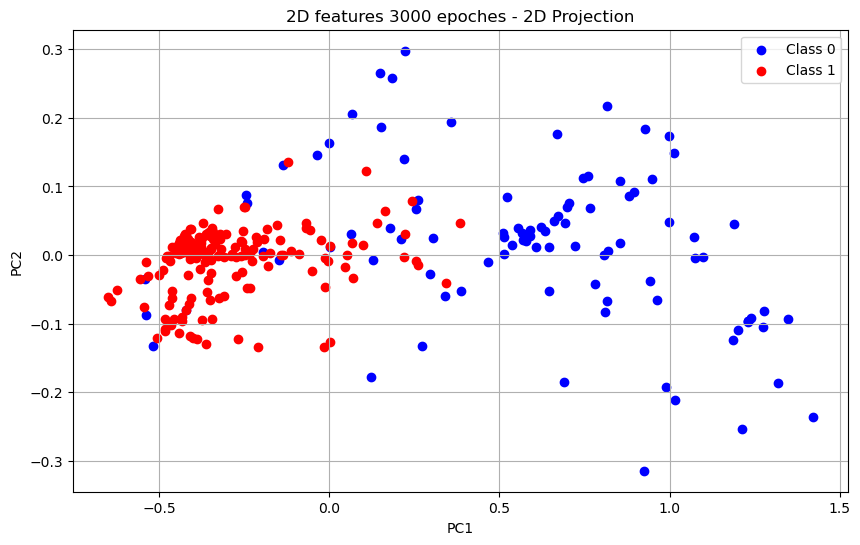

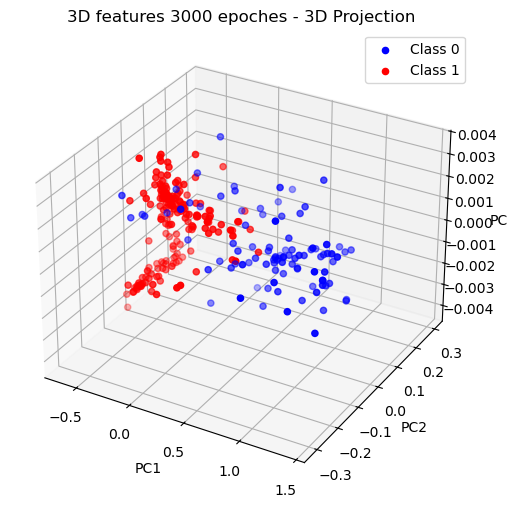

Epoch 3101/7001, Loss: 0.3088889770926306
Epoch 3201/7001, Loss: 0.30839946008258734
Epoch 3301/7001, Loss: 0.3079952573721867
Epoch 3401/7001, Loss: 0.3075820578479387
Epoch 3501/7001, Loss: 0.3072403027161584
Epoch 3601/7001, Loss: 0.30683609042595794
Epoch 3701/7001, Loss: 0.3065464175791684
Epoch 3801/7001, Loss: 0.30621181889318955
Epoch 3901/7001, Loss: 0.30590788273677916
Epoch 4001/7001, Loss: 0.3055007467608485
Epoch 4101/7001, Loss: 0.3050270177436676
Epoch 4201/7001, Loss: 0.3044195570349749
Epoch 4301/7001, Loss: 0.3038545721907499
Epoch 4401/7001, Loss: 0.30338276065231773
Epoch 4501/7001, Loss: 0.3028143502309425
Epoch 4601/7001, Loss: 0.30223811815523643
Epoch 4701/7001, Loss: 0.3018020945220776
Epoch 4801/7001, Loss: 0.30138632647507335
Epoch 4901/7001, Loss: 0.30112719499254875
Epoch 5001/7001, Loss: 0.30085487669080685


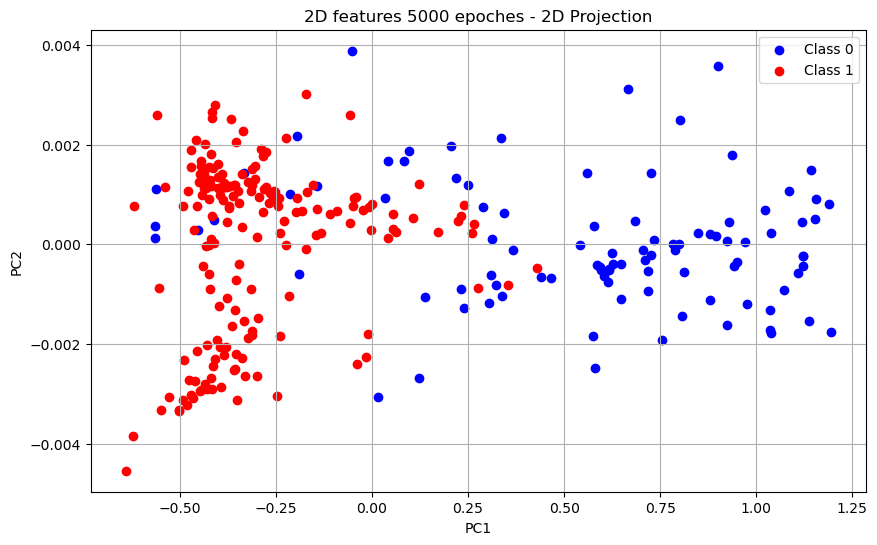

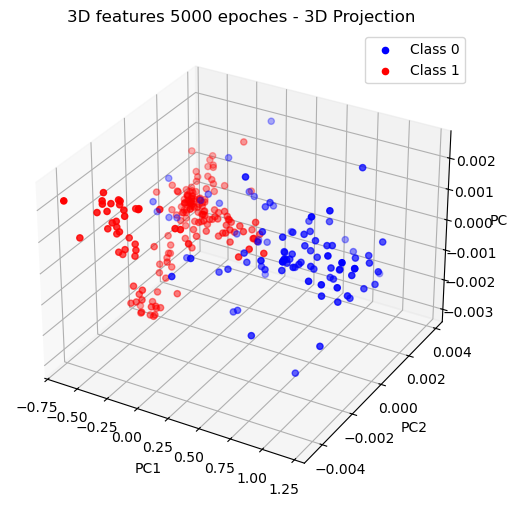

Epoch 5101/7001, Loss: 0.30063468057835835
Epoch 5201/7001, Loss: 0.3004869289759154
Epoch 5301/7001, Loss: 0.3003329357442964
Epoch 5401/7001, Loss: 0.3002483889909672
Epoch 5501/7001, Loss: 0.30005621030412927
Epoch 5601/7001, Loss: 0.29998961996008305
Epoch 5701/7001, Loss: 0.29986399251446305
Epoch 5801/7001, Loss: 0.2997851643746962
Epoch 5901/7001, Loss: 0.2997693103441156
Epoch 6001/7001, Loss: 0.2997656684220896
Epoch 6101/7001, Loss: 0.29970241508103396
Epoch 6201/7001, Loss: 0.29966317521392827
Epoch 6301/7001, Loss: 0.2995613077286093
Epoch 6401/7001, Loss: 0.2995711590954556
Epoch 6501/7001, Loss: 0.29951471232243515
Epoch 6601/7001, Loss: 0.299452453493649
Epoch 6701/7001, Loss: 0.29944300219367675
Epoch 6801/7001, Loss: 0.2994554588089177
Epoch 6901/7001, Loss: 0.2993686980722961
Epoch 7001/7001, Loss: 0.2993958763017229


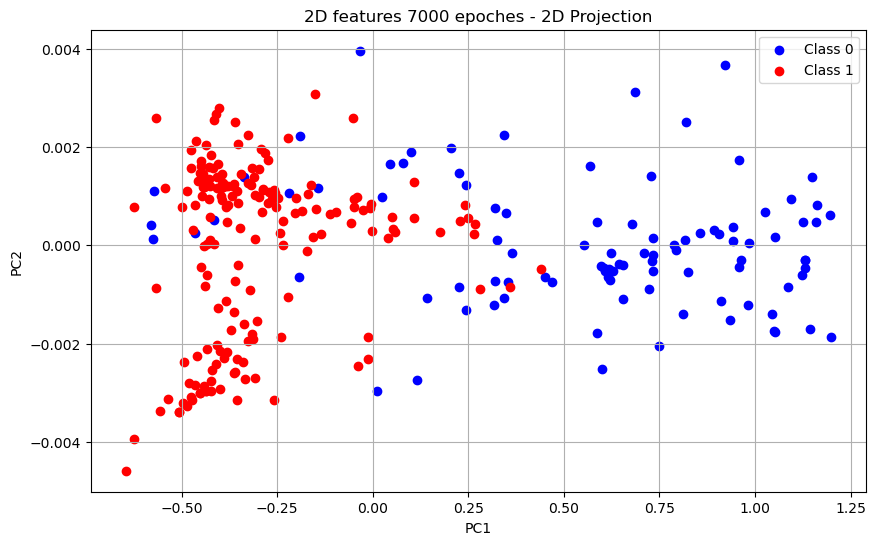

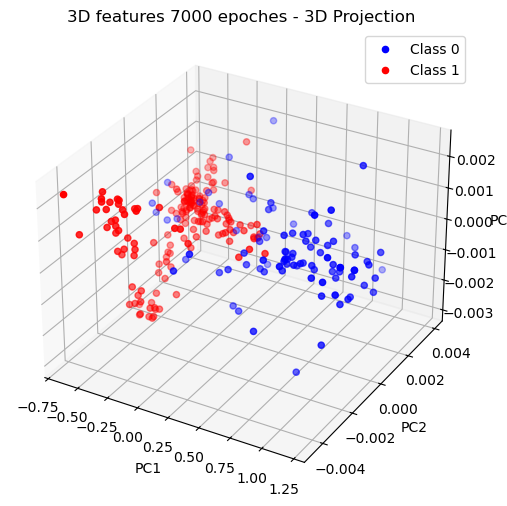

In [85]:
# Step 4: Training with 16 nodes
hidden_dim = 16 # Example hidden layer size (you can adjust this)
train_losses = []
test_losses = []

# Train the model
W1, b1, W2, b2 = train(
    X_train,
    Y_train,
    input_dim,
    hidden_dim,
    output_dim,
    epochs,
    learning_rate,
    train_losses,
    X_test,
    Y_test,
    test_losses,
)

# Save all weights and biases
save_parameters(W1, b1, W2, b2)

Good or Bad - Binary Cross Entropy Loss on Train Set: 2.763103928755161
Good or Bad - Binary Cross Entropy Loss on Test Set: 2.724187361483342


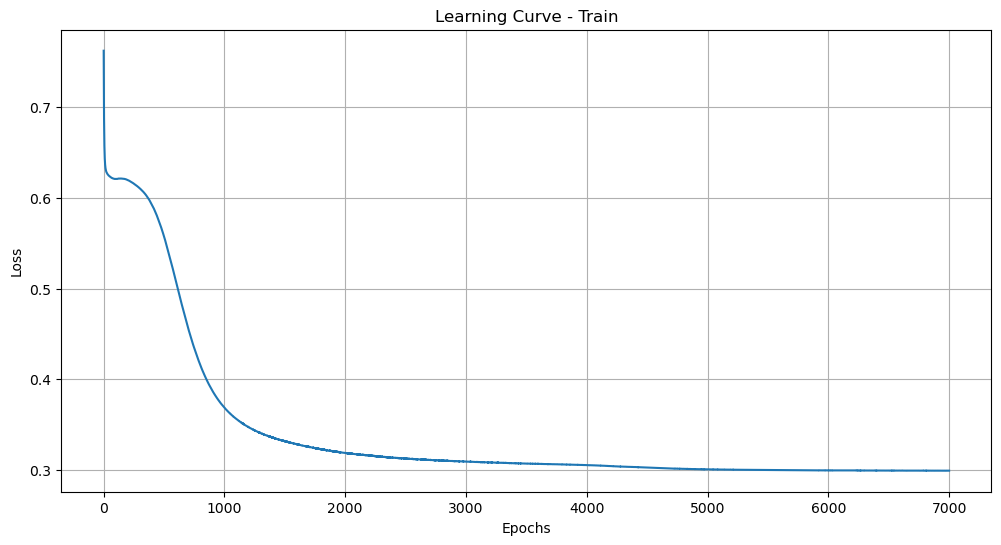

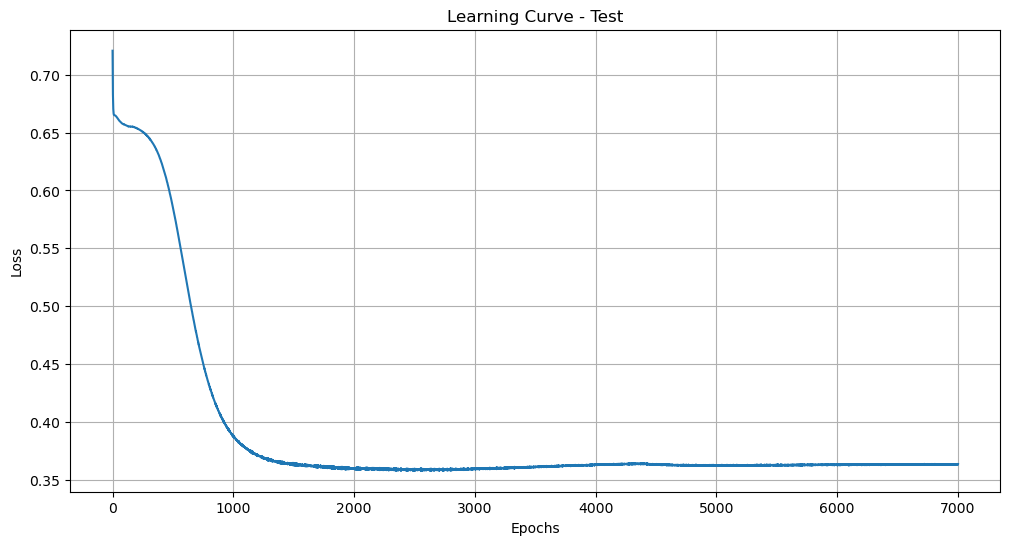

In [86]:
# Question 2-a: Please try to classify the Ionosphere data by minimizing the cross-entropy error function
_, _, _, Y_pred_test = forward_propagation(X_test, W1, b1, W2, b2)
_, _, _, Y_pred_train = forward_propagation(X_train, W1, b1, W2, b2)

# Correct the answer of prediction
Y_pred_train = np.where(Y_pred_train < 0.5, 0, 1)
Y_pred_test = np.where(Y_pred_test < 0.5, 0, 1)

# Question 2-b: Show your (1) network architecture (number of hidden layers and neurons), (2) learning curve, (3) training error rate, (4) test error rate

# Evaluate the performance for TRAIN using Calculate Binary Cross-Entropy Loss on the Training Set
bce_loss_train = binary_cross_entropy_loss(Y_train, Y_pred_train)  # Y_pred_train are the predicted probabilities (A2)
print(f"Good or Bad - Binary Cross Entropy Loss on Train Set: {bce_loss_train}")

# Calculate Binary Cross-Entropy Loss on the Test Set
bce_loss_test = binary_cross_entropy_loss(Y_test, Y_pred_test)  # Y_pred_test are the predicted probabilities (A2)
print(f"Good or Bad - Binary Cross Entropy Loss on Test Set: {bce_loss_test}")

# Visualize the learning curve (TRAIN DATA)
plt.figure(figsize=(12, 6))
plt.plot(train_losses)
plt.title("Learning Curve - Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Visualize the learning curve (TEST DATA)
plt.figure(figsize=(12, 6))
plt.plot(test_losses)
plt.title("Learning Curve - Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Epoch 1/7001, Loss: 0.7052367031229723


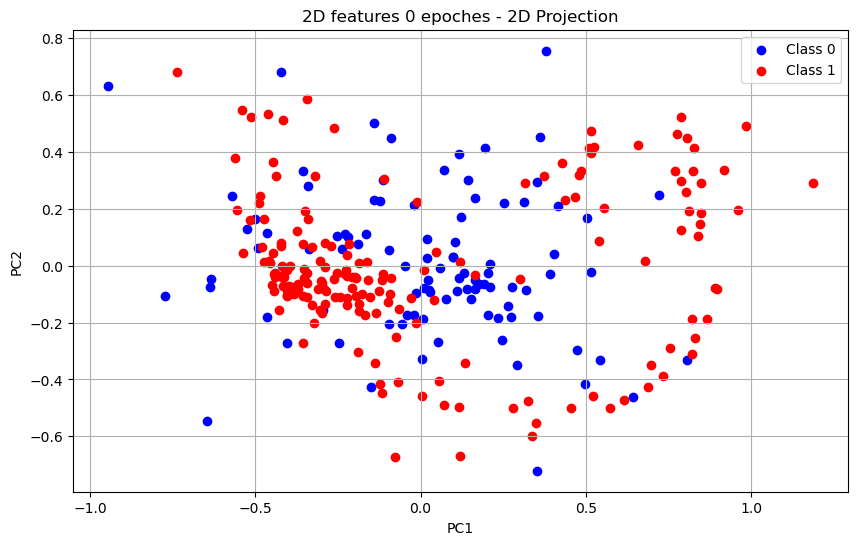

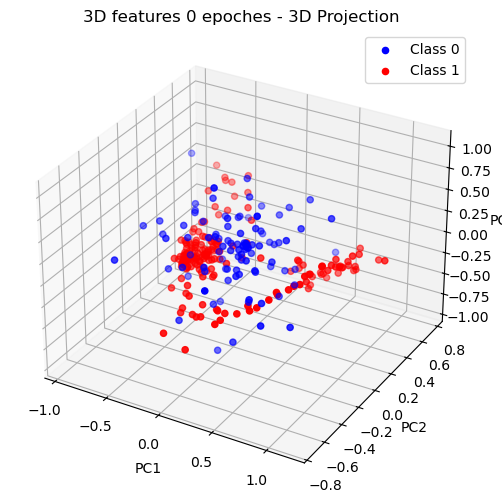

Epoch 101/7001, Loss: 0.6190549851488802
Epoch 201/7001, Loss: 0.6198832255318543
Epoch 301/7001, Loss: 0.6140667018644548
Epoch 401/7001, Loss: 0.6021011517593613
Epoch 501/7001, Loss: 0.5763519418334809
Epoch 601/7001, Loss: 0.5306660736335468
Epoch 701/7001, Loss: 0.4742697095669838
Epoch 801/7001, Loss: 0.42582190616811944
Epoch 901/7001, Loss: 0.3918634259491832
Epoch 1001/7001, Loss: 0.3693140591929673


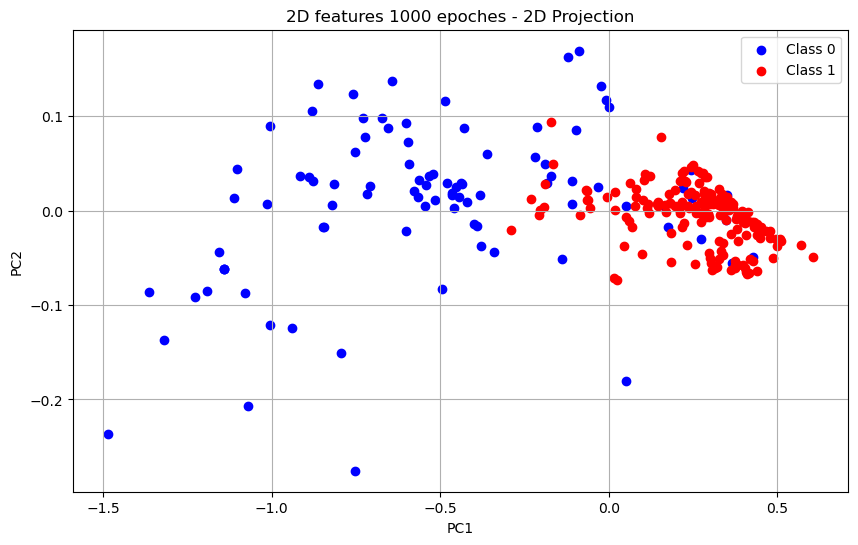

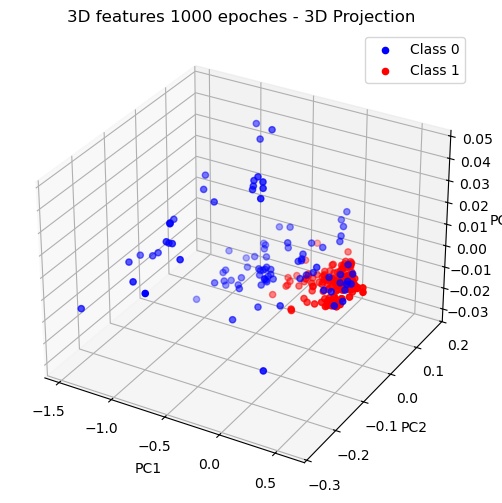

Epoch 1101/7001, Loss: 0.3540493485290016
Epoch 1201/7001, Loss: 0.34330239958397246
Epoch 1301/7001, Loss: 0.335383451059692
Epoch 1401/7001, Loss: 0.3294479901173238
Epoch 1501/7001, Loss: 0.3247725416040066
Epoch 1601/7001, Loss: 0.321221994694213
Epoch 1701/7001, Loss: 0.31841416061261724
Epoch 1801/7001, Loss: 0.31615859021619547
Epoch 1901/7001, Loss: 0.3142667615952036
Epoch 2001/7001, Loss: 0.3127689747231532


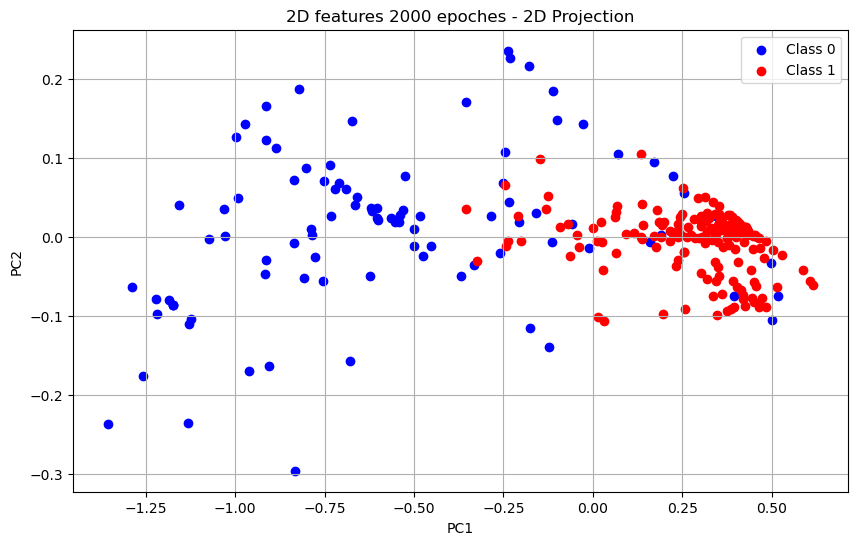

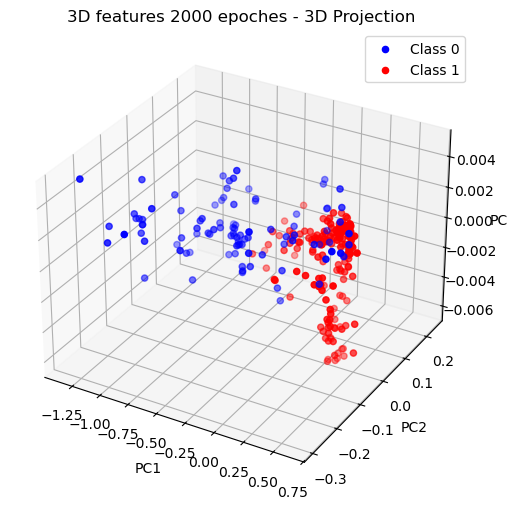

Epoch 2101/7001, Loss: 0.31145082953907094
Epoch 2201/7001, Loss: 0.31033520903913414
Epoch 2301/7001, Loss: 0.30940672000019215
Epoch 2401/7001, Loss: 0.30852983631160225
Epoch 2501/7001, Loss: 0.3077251291338222
Epoch 2601/7001, Loss: 0.3068387635652245
Epoch 2701/7001, Loss: 0.30575269941342725
Epoch 2801/7001, Loss: 0.3049846756409211
Epoch 2901/7001, Loss: 0.3041557444762988
Epoch 3001/7001, Loss: 0.30342055738730045


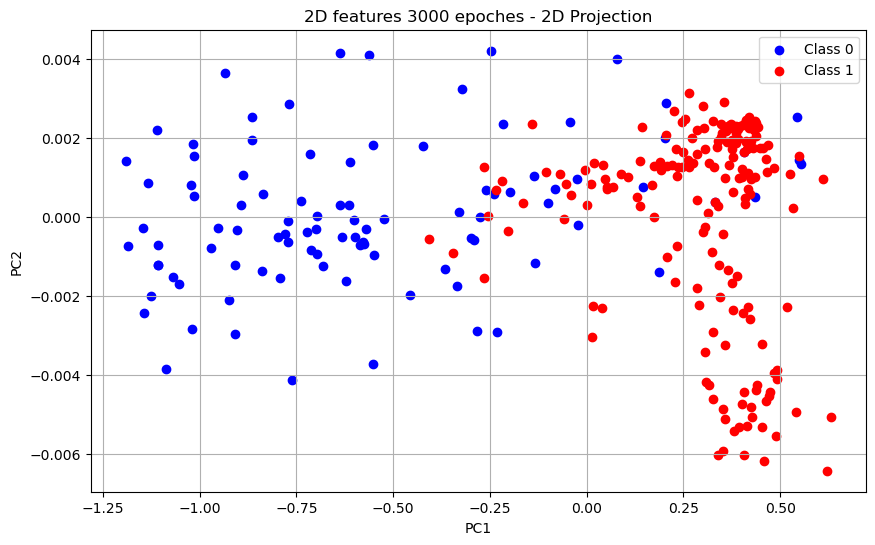

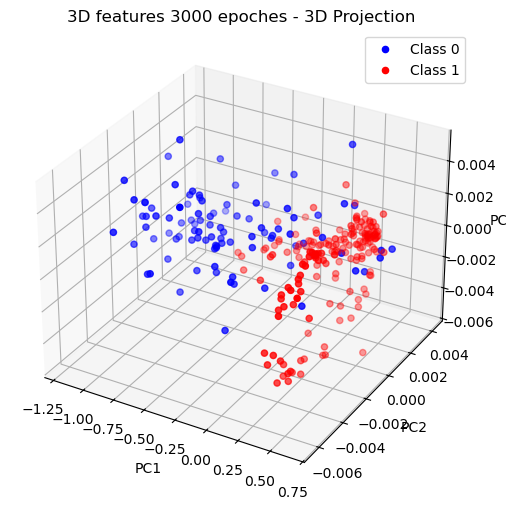

Epoch 3101/7001, Loss: 0.3028065468006765
Epoch 3201/7001, Loss: 0.3023769387882374
Epoch 3301/7001, Loss: 0.3018790988097952
Epoch 3401/7001, Loss: 0.3015665995455117
Epoch 3501/7001, Loss: 0.30133588578151715
Epoch 3601/7001, Loss: 0.301092325766041
Epoch 3701/7001, Loss: 0.30090492746934167
Epoch 3801/7001, Loss: 0.3006636928350785
Epoch 3901/7001, Loss: 0.3004399441197109
Epoch 4001/7001, Loss: 0.30030152647404096


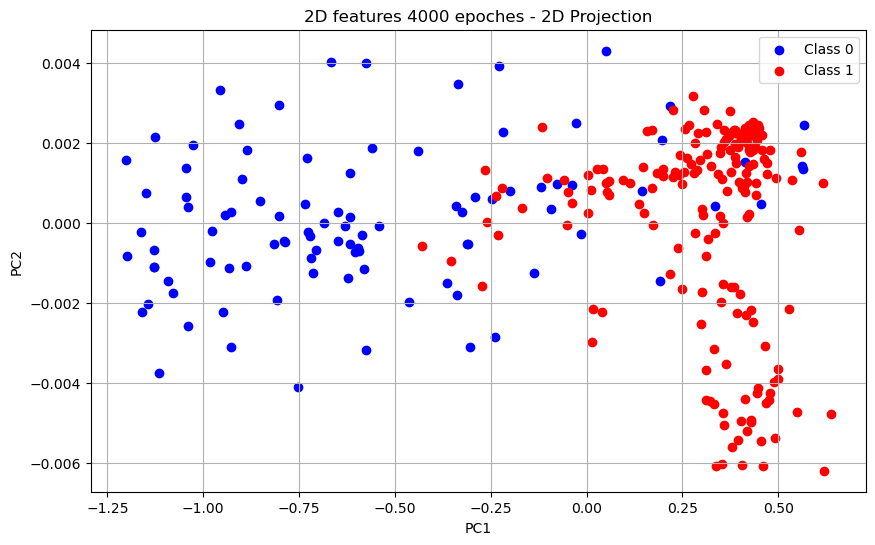

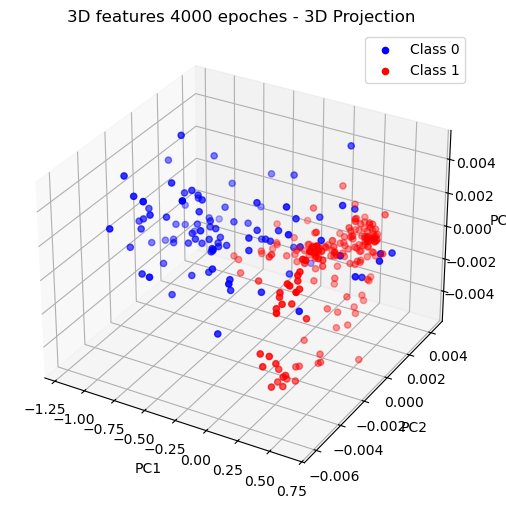

Epoch 4101/7001, Loss: 0.3001768136482244
Epoch 4201/7001, Loss: 0.3000430104973391
Epoch 4301/7001, Loss: 0.29998100539601363
Epoch 4401/7001, Loss: 0.2999246978712802
Epoch 4501/7001, Loss: 0.2997976596781346
Epoch 4601/7001, Loss: 0.29973960045439
Epoch 4701/7001, Loss: 0.29975128892324393
Epoch 4801/7001, Loss: 0.29977463171876245
Epoch 4901/7001, Loss: 0.29970093330761177
Epoch 5001/7001, Loss: 0.2995647494142085


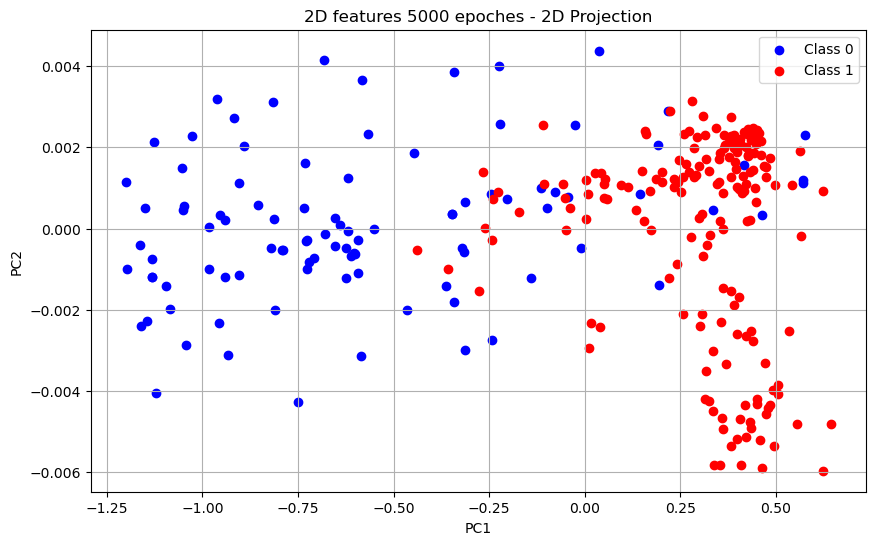

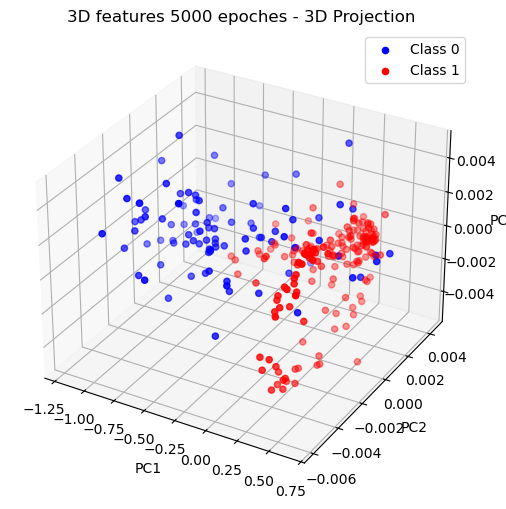

Epoch 5101/7001, Loss: 0.2995249720939756
Epoch 5201/7001, Loss: 0.29961048356975345
Epoch 5301/7001, Loss: 0.29943860625167823
Epoch 5401/7001, Loss: 0.29949167221928896
Epoch 5501/7001, Loss: 0.29937875623865257
Epoch 5601/7001, Loss: 0.29945433690480555
Epoch 5701/7001, Loss: 0.29947345440899625
Epoch 5801/7001, Loss: 0.2993273260104378
Epoch 5901/7001, Loss: 0.2992826034303085
Epoch 6001/7001, Loss: 0.29928317271257243


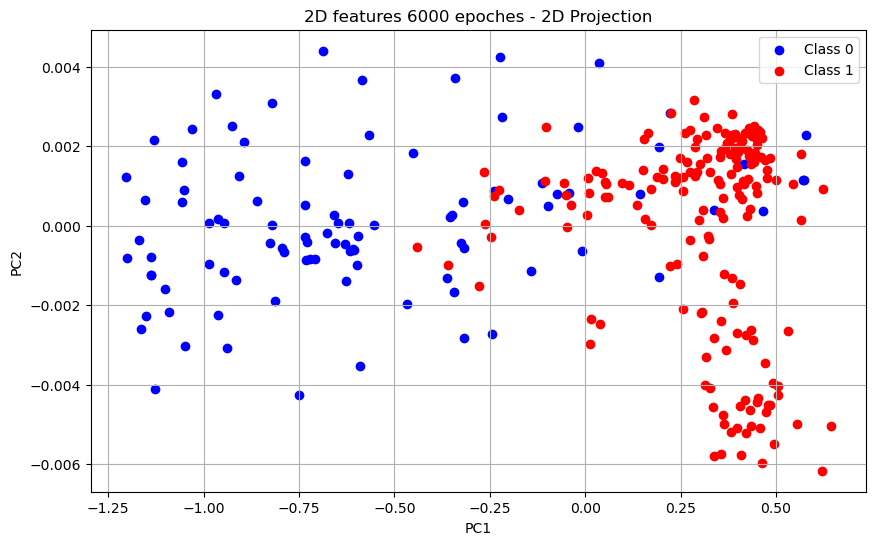

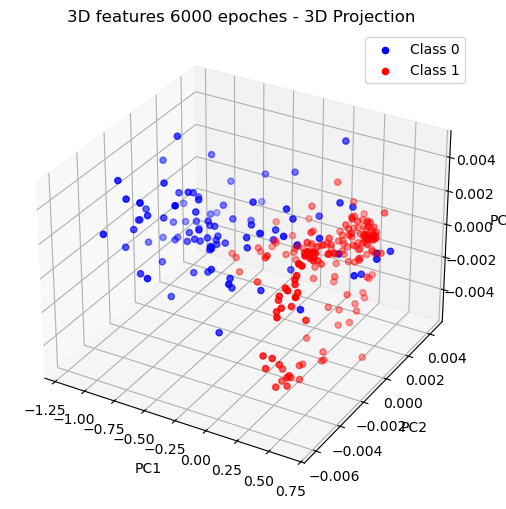

Epoch 6101/7001, Loss: 0.2992480335384988
Epoch 6201/7001, Loss: 0.29924082768780685
Epoch 6301/7001, Loss: 0.2992171610857921
Epoch 6401/7001, Loss: 0.2992642904236026
Epoch 6501/7001, Loss: 0.2991991548957592
Epoch 6601/7001, Loss: 0.29919448754136824
Epoch 6701/7001, Loss: 0.2991861362342928
Epoch 6801/7001, Loss: 0.2991818242855205
Epoch 6901/7001, Loss: 0.299170346287077
Epoch 7001/7001, Loss: 0.2991461017074222


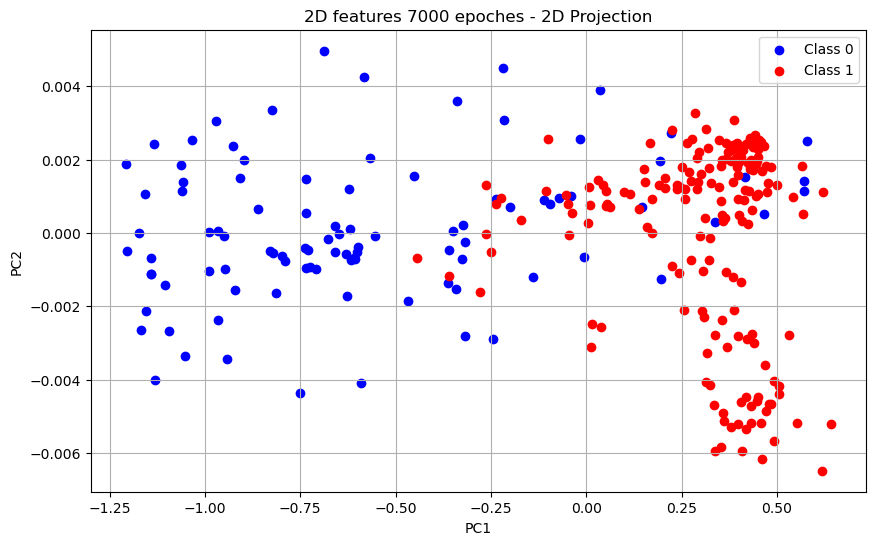

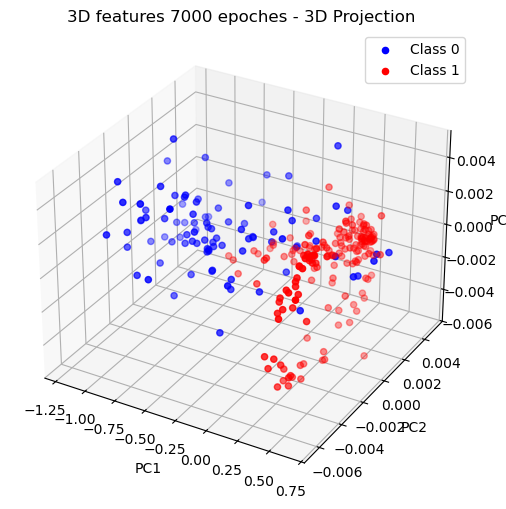

In [76]:
# Step 4: Training with 32 nodes
hidden_dim = 32 # Example hidden layer size (you can adjust this)
train_losses = []
test_losses = []

# Train the model
W1, b1, W2, b2 = train(
    X_train,
    Y_train,
    input_dim,
    hidden_dim,
    output_dim,
    epochs,
    learning_rate,
    train_losses,
    X_test,
    Y_test,
    test_losses,
)

# Save all weights and biases
save_parameters(W1, b1, W2, b2)

Good or Bad - Binary Cross Entropy Loss on Train Set: 2.763103849748143
Good or Bad - Binary Cross Entropy Loss on Test Set: 2.724187361483342


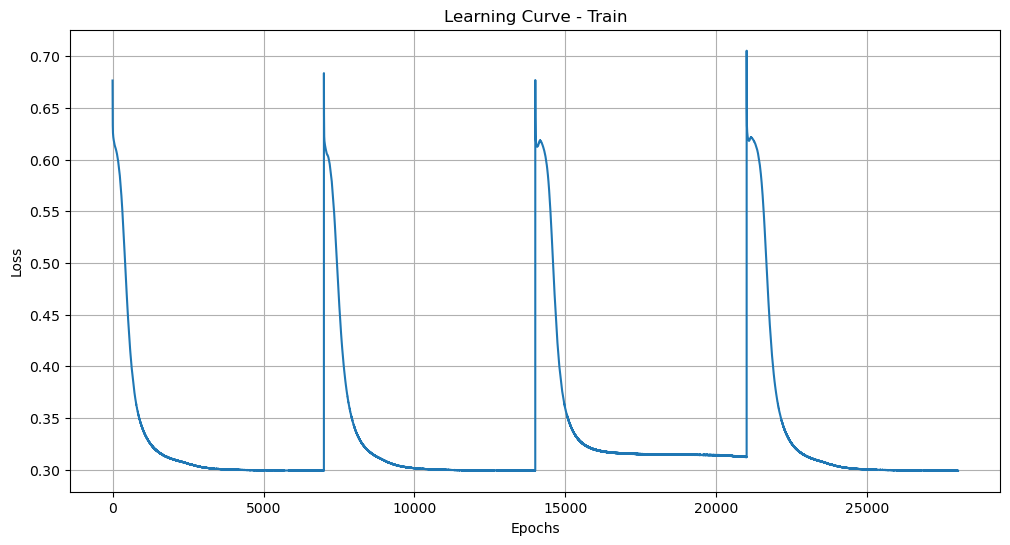

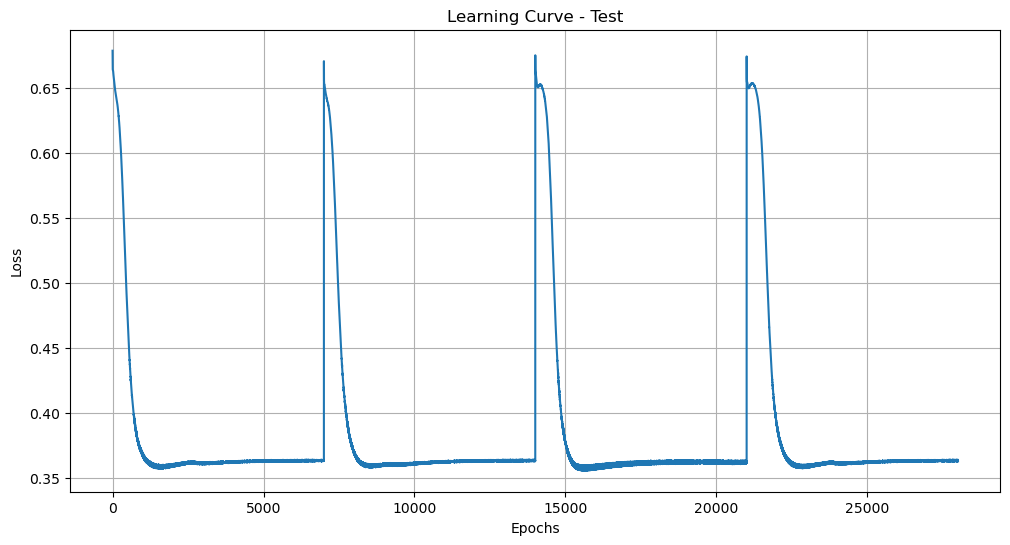

In [77]:
# Question 2-a: Please try to classify the Ionosphere data by minimizing the cross-entropy error function
_, _, _, Y_pred_test = forward_propagation(X_test, W1, b1, W2, b2)
_, _, _, Y_pred_train = forward_propagation(X_train, W1, b1, W2, b2)

# Correct the answer of prediction
Y_pred_train = np.where(Y_pred_train < 0.5, 0, 1)
Y_pred_test = np.where(Y_pred_test < 0.5, 0, 1)

# Question 2-b: Show your (1) network architecture (number of hidden layers and neurons), (2) learning curve, (3) training error rate, (4) test error rate

# Evaluate the performance for TRAIN using Calculate Binary Cross-Entropy Loss on the Training Set
bce_loss_train = binary_cross_entropy_loss(Y_train, Y_pred_train)  # Y_pred_train are the predicted probabilities (A2)
print(f"Good or Bad - Binary Cross Entropy Loss on Train Set: {bce_loss_train}")

# Calculate Binary Cross-Entropy Loss on the Test Set
bce_loss_test = binary_cross_entropy_loss(Y_test, Y_pred_test)  # Y_pred_test are the predicted probabilities (A2)
print(f"Good or Bad - Binary Cross Entropy Loss on Test Set: {bce_loss_test}")

# Visualize the learning curve (TRAIN DATA)
plt.figure(figsize=(12, 6))
plt.plot(train_losses)
plt.title("Learning Curve - Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Visualize the learning curve (TEST DATA)
plt.figure(figsize=(12, 6))
plt.plot(test_losses)
plt.title("Learning Curve - Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()